In [56]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
import random
import seaborn as sns
import fnmatch
import tqdm as tqdm

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from os import listdir
import cv2
from glob import glob

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# pip install -U imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

In [44]:
files = listdir("images/")
print(len(files))

281


In [18]:
#looking at first 10 folders
files[0:10]

['9036',
 '10268',
 '10257',
 '8913',
 '13613',
 '8914',
 '15510',
 '10259',
 '16165',
 '10292']

In [45]:
base_path = "images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
print("No. of Patients:",len(folder))

No. of Patients: 280


In [46]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + '/' + str(c) + '/'
        try:
            subfiles = [f for f in listdir(class_path) if not f.startswith('.')]
            total_images += len(subfiles)
        except NotADirectoryError:
            pass

print("Total Images in dataset:", total_images)

Total Images in dataset: 277524


In [47]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0, 1]:
        class_path = patient_path + "/" + str(c) + "/"
        try:
            subfiles = [f for f in listdir(class_path) if not f.startswith('.')]
            for m in range(len(subfiles)):
                image_path = subfiles[m]
                data.iloc[k]["path"] = class_path + image_path
                data.iloc[k]["target"] = c
                data.iloc[k]["patient_id"] = patient_id
                k += 1
        except NotADirectoryError:
            pass

data.head()

patient_id                                               path target
0       9036  images/IDC_regular_ps50_idx5/9036/0/9036_idx5_...      0
1       9036  images/IDC_regular_ps50_idx5/9036/0/9036_idx5_...      0
2       9036  images/IDC_regular_ps50_idx5/9036/0/9036_idx5_...      0
3       9036  images/IDC_regular_ps50_idx5/9036/0/9036_idx5_...      0
4       9036  images/IDC_regular_ps50_idx5/9036/0/9036_idx5_...      0

In [48]:
import pandas as pd

# Assuming 'data' is your DataFrame with features
features_table_data = [
    {"Feature Name": "patient_id", "Description": "Patient ID", "Data Type": str(data["patient_id"].dtype)},
    {"Feature Name": "image_path", "Description": "Image Path", "Data Type": str(data["path"].dtype)},
    {"Feature Name": "class", "Description": "IDC Class (0 or 1)", "Data Type": str(data["target"].dtype)}
]

# Create the Features table DataFrame
features_table = pd.DataFrame(features_table_data)

# Display the Features table
print(features_table)


  Feature Name         Description Data Type
0   patient_id          Patient ID    object
1   image_path          Image Path    object
2        class  IDC Class (0 or 1)    object


In [26]:
data.shape

(277524, 3)

3 columns (patient_id, image_path, target) and 277524 rows (patients).

In [28]:
data.target

0         0
1         0
2         0
3         0
4         0
         ..
277519    1
277520    1
277521    1
277522    1
277523    1
Name: target, Length: 277524, dtype: object

/var/folders/4q/5prb21rs2517wykwwgg63gyh0000gn/T/ipykernel_87182/3505179311.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
/var/folders/4q/5prb21rs2517wykwwgg63gyh0000gn/T/ipykernel_87182/3505179311.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147e

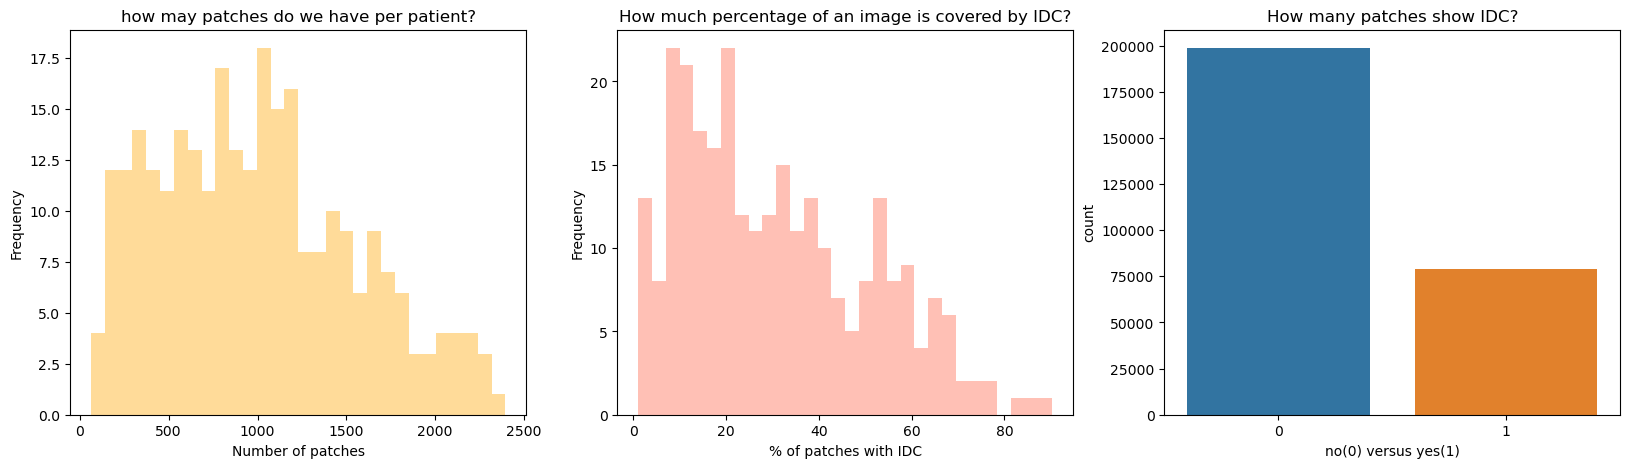

In [58]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
canxer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3,figsize = (20,5))
sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('how may patches do we have per patient?')
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data, x = "target");
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

Exploring the data, we see that most patients have around 1000 patches. Number of patches with IDC are around 20% and alot more patches show no IDC compared to the number of patches showing IDC.

In [59]:
# Convert 'target' to int
data.target = data.target.astype(int)

In [60]:
# Assuming '1' represents IDC-positive and '0' represents IDC-negative
labels = [1 if '1' in file else 0 for file in files]

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

files_train, files_temp = train_test_split(files, test_size=0.4, random_state=42)
files_val, files_test = train_test_split(files_temp, test_size=0.5, random_state=42)

# Make sure to create corresponding label arrays for training, validation, and test sets
labels_train = [1 if '1' in file else 0 for file in files_train]
labels_val = [1 if '1' in file else 0 for file in files_val]
labels_test = [1 if '1' in file else 0 for file in files_test]


In [62]:
#Data loading and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from os.path import join, isfile
from os.path import join, isfile, isdir 

# Specify image dimensions
img_width, img_height = 50, 50

from os.path import join, isdir, isfile

def load_and_preprocess_image(path):
    # If it's a directory, get a random file from it
    if isdir(path):
        img_files = [f for f in listdir(path) if isfile(join(path, f))]
        if img_files:
            img_path = join(path, random.choice(img_files))
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to be between 0 and 1
            return img_array
    else:
        img_path = path
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to be between 0 and 1
        return img_array

# Example of using data augmentation on a single image or a random image from a directory
sample_image_path = "images/IDC_regular_ps50_idx5/" + files_train[0] + "/"
sample_image = load_and_preprocess_image(sample_image_path)


In [14]:
image_names = glob('images/**/*.png', recursive=True)
print("\nTotal number of images in the dataset :", len(image_names))
print("\nSample image names from the dataset :", *random.sample(image_names, 5), sep='\n')


Total number of images in the dataset : 277524

Sample image names from the dataset :
images/10288/0/10288_idx5_x2301_y1601_class0.png
images/10272/0/10272_idx5_x1301_y701_class0.png
images/14156/0/14156_idx5_x1051_y1501_class0.png
images/13916/0/13916_idx5_x2151_y1401_class0.png
images/12752/0/12752_idx5_x1851_y1951_class0.png


The image name format comprises the patient ID, followed by the x and y coordinates of the image patch extracted from the Whole Slide Images (WSI). Finally, the image is assigned to a class: class1 represents a positive patch (IDC+), and class0 represents a negative patch (IDC-).

EDA continued

In [15]:
from PIL import Image
import fnmatch
import tqdm

# Group the images into class0 and class1
class_zero = fnmatch.filter(image_names, '*class0.png')
class_one = fnmatch.filter(image_names, '*class1.png')

# Print example image patch name from each class
print("\nPositive and Negative image name example:")
print("IDC(-):", class_zero[0])
print("IDC(+):", class_one[0], '\n')

# Check if all the images have the same dimensions
dimensions = set()
max_width, max_height = 0, 0

for img_path in tqdm.tqdm(image_names):
    with Image.open(img_path) as img:
        dim = img.size
        dimensions.add(dim)
        max_width = max(max_width, dim[0])
        max_height = max(max_height, dim[1])

print("\nDifferent image patch dimensions:", dimensions)
print("The total number of different image patch dimensions:", len(dimensions))
print("max_width:", max_width, "  max_height:", max_height, "\n")



Positive and Negative image name example:
IDC(-): images/9036/0/9036_idx5_x1051_y2401_class0.png
IDC(+): images/9036/1/9036_idx5_x1851_y1351_class1.png 



100%|█████████████████████████████████| 277524/277524 [00:40<00:00, 6818.04it/s]


Different image patch dimensions: {(50, 6), (46, 48), (12, 43), (50, 27), (50, 36), (50, 45), (42, 41), (42, 50), (2, 50), (46, 50), (50, 20), (50, 29), (50, 38), (50, 47), (50, 13), (12, 38), (21, 50), (50, 31), (50, 40), (36, 50), (50, 49), (21, 34), (50, 15), (5, 25), (50, 24), (50, 33), (50, 42), (2, 29), (11, 50), (50, 8), (26, 50), (50, 17), (50, 26), (50, 35), (50, 44), (50, 1), (32, 50), (50, 10), (50, 19), (32, 13), (42, 15), (50, 28), (26, 6), (36, 38), (50, 37), (2, 24), (50, 3), (50, 30), (2, 8), (22, 50), (5, 43), (2, 26), (50, 5), (42, 1), (50, 14), (50, 23), (41, 41), (41, 50), (12, 23), (50, 7), (1, 50), (50, 16), (50, 25), (50, 9), (16, 41), (31, 50), (2, 23), (50, 39), (50, 48), (32, 42), (50, 2), (50, 11), (22, 40), (50, 41), (50, 50), (50, 4), (12, 50), (50, 34), (50, 43)}
The total number of different image patch dimensions: 79
max_width: 50   max_height: 50 



The analysis reveals that the image patches have a maximum height and width of 50 pixels, with 79 different dimensions present in the dataset. To standardize the dataset, all images will be resized to a uniform size of 50x50. Notably, certain image patches exhibit dimensions as small as 2 pixels in either height or width. While these patches might pose challenges for classification, for the purposes of this analysis, all image patches will be retained by resizing them to the standardized dimensions of 50x50.

The images will be converted into a list and then into a pandas DataFrame for ease of manipulation. The dimensions will be set to 50x50, and a specified percentage of randomly chosen image patches from the dataset will be processed.

In [16]:
# Initialize lists to store images and labels
images = []
labels = []
width, height = 50, 50

# Define the total percentage of image patches to process through
percent = .3
total_images_to_process = int(len(image_names) * percent)
selected_images = np.random.choice(image_names, size=total_images_to_process)

# Process the selected percentage of image patches at random from the dataset
for img in tqdm.tqdm(selected_images):
    image = cv2.imread(img)
    
    # Resize all images to size 50x50
    images.append(cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC))
    
    # Assign labels based on class
    if img in class_zero:
        labels.append(0)
    if img in class_one:
        labels.append(1)

# Assign the arrays to a pandas DataFrame
temp_df = pd.DataFrame({"Images": images, "Labels": labels})
print("Total image patches taken for processing:", total_images_to_process)

100%|████████████████████████████████████| 83257/83257 [02:21<00:00, 588.53it/s]

Total image patches taken for processing: 83257



Plotting sample image patches after preparing them into a more manageable format. Let's visualize a few of them to get an idea of their appearance.

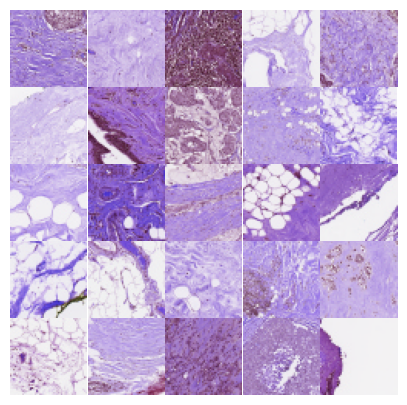

In [17]:
# Plot a few random images
def plot_images(images):
    random_index = np.random.randint(images.shape[0], size=25)
    bunch_of_images = images.iloc[random_index]

    count = 0
    plt.rcParams['figure.figsize'] = (5, 5)
    plt.subplots_adjust(wspace=0, hspace=0)

    for image in bunch_of_images:
        plt.subplot(5, 5, count + 1)
        plt.imshow(image)
        plt.axis('off')
        count += 1

    plt.show()

plot_images(temp_df["Images"])

Let's visualize positive and negative images separately. This approach can assist us in identifying patterns between positive and negative images, aiding in the selection of effective Data Augmentation Techniques.

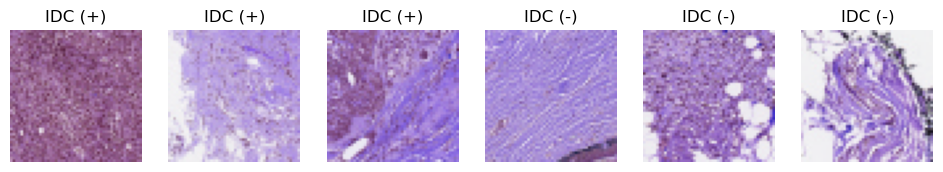

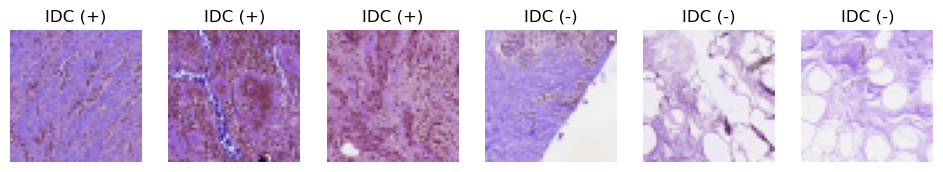

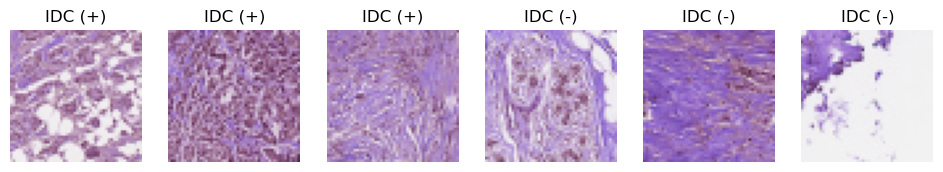

In [19]:
# Sample the positive and negative into different variables
positive_images = temp_df["Images"].loc[temp_df["Labels"] == 1]
negative_images = temp_df["Images"].loc[temp_df["Labels"] == 0]

# to print random positive and negative images
index = np.random.randint(positive_images.shape[0])

sample_positive_images = positive_images.iloc[index:index+9]
sample_negative_images = negative_images.iloc[index:index+9]

count = 0
for row in range(3):
    plt.figure(figsize=(16, 8))
    for col in range(3):
        plt.subplot(1,8,col+1)
        plt.title('IDC (+)')
        plt.imshow(sample_positive_images.iloc[count])
        #print(col+1)
        plt.axis('off')       
        plt.subplot(1,8,col+4)
        plt.title('IDC (-)')
        plt.imshow(sample_negative_images.iloc[count])
        plt.axis('off')
        count += 1
plt.show()

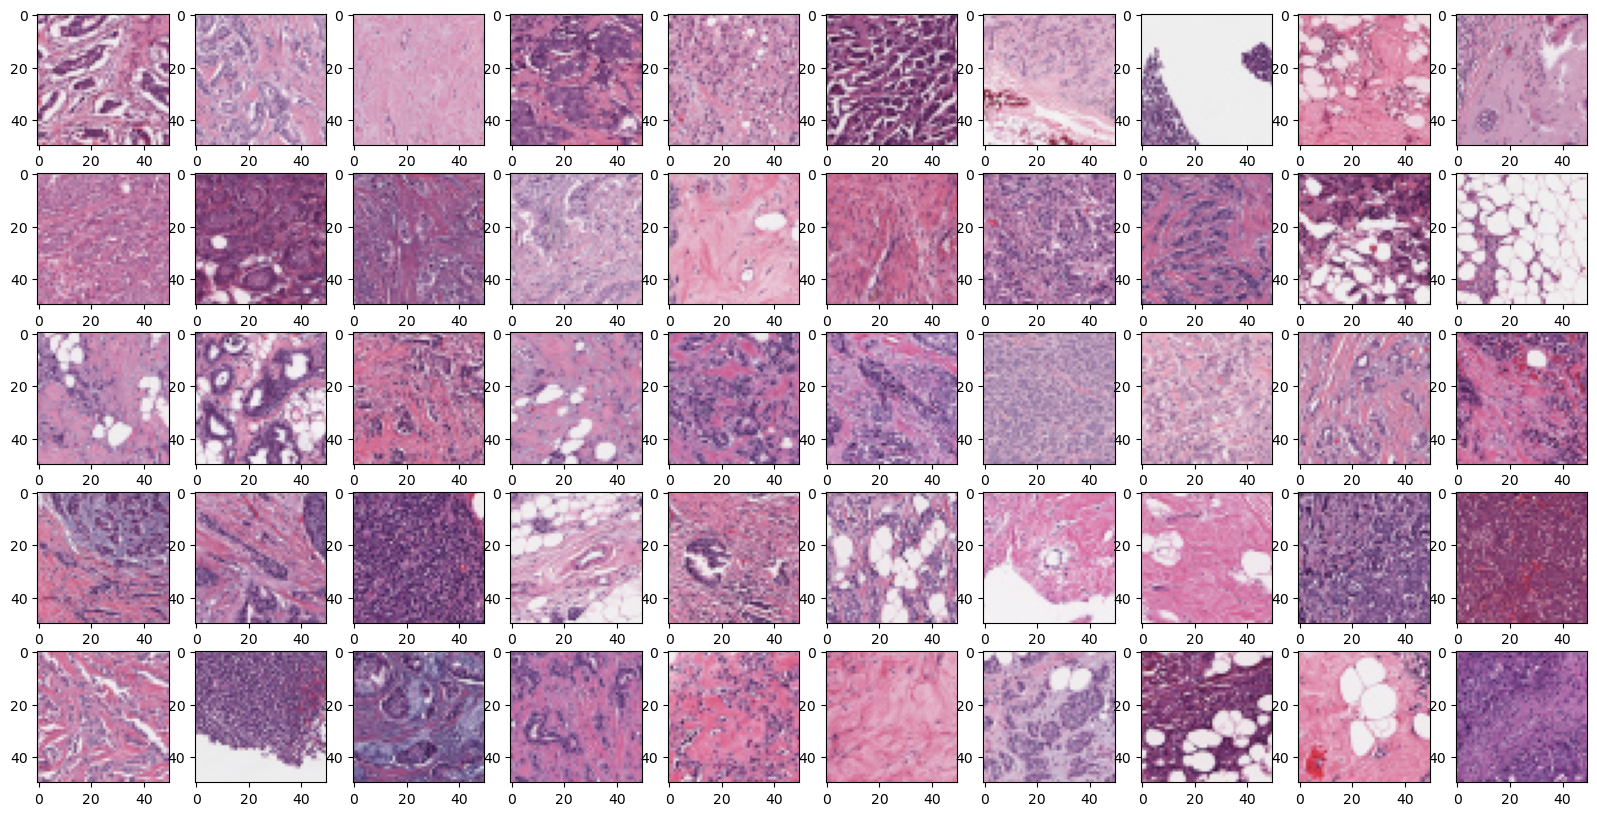

In [20]:

cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

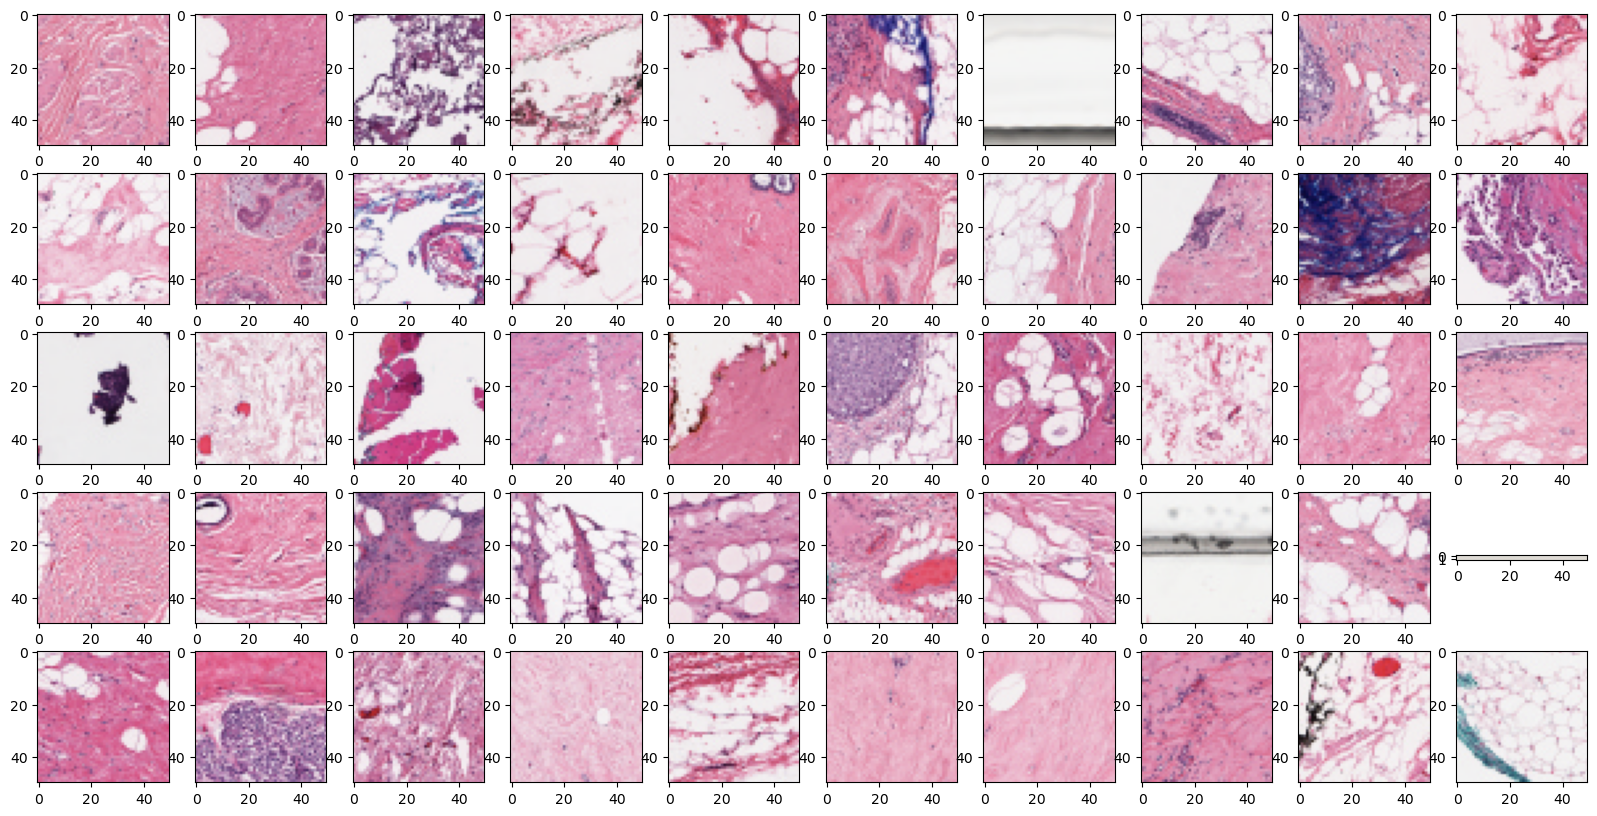

In [21]:
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = non_cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




Now, we will create a histogram of the RGB pixel values for an image patch. This visualization will reveal the most prominent pixel values. 



In [22]:
from scipy.stats import ttest_ind

def calculate_average_hsv(image_path):
    # Read the image in RGB format
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to HSV format
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Calculate average H, S, and V components
    average_h = image_hsv[:, :, 0].mean()
    average_s = image_hsv[:, :, 1].mean()
    average_v = image_hsv[:, :, 2].mean()

    return average_h, average_s, average_v

# Assuming 'data' is the DataFrame with features
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

# Calculate average HSV components for cancerous and non-cancerous images
cancerous_hsv_list = [calculate_average_hsv(data.iloc[idx]["path"]) for idx in cancer_selection]
non_cancerous_hsv_list = [calculate_average_hsv(data.iloc[idx]["path"]) for idx in non_cancer_selection]

# Perform t-test
t_statistic, p_value = ttest_ind(cancerous_hsv_list, non_cancerous_hsv_list)

# print("Average HSV components for cancerous images:", cancerous_hsv_list)
# print("Average HSV components for non-cancerous images:", non_cancerous_hsv_list)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: [ 2.27193993  4.29637485 -7.5594786 ]
P-Value: [2.52759745e-02 4.09449343e-05 2.18155667e-11]


T-Statistic (RGB): [-6.43224983 -4.05527336 -3.41698292]
P-Value (RGB): [4.61735332e-09 1.00553819e-04 9.23307910e-04]


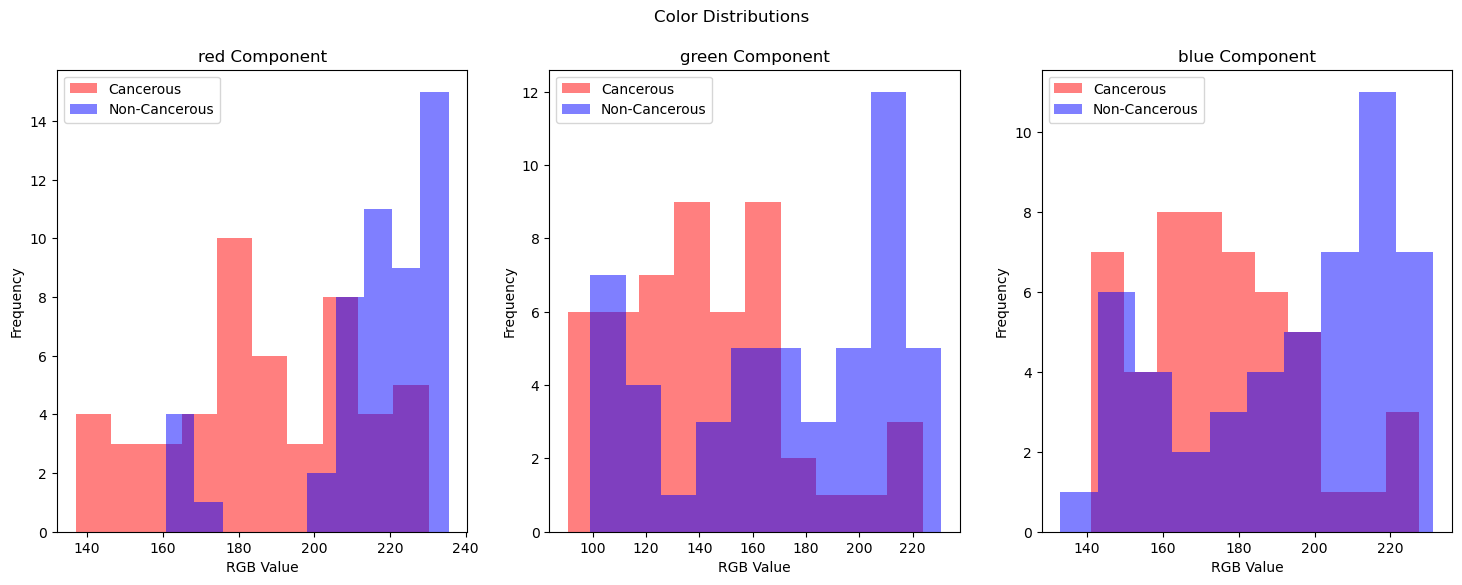

In [23]:
from scipy.stats import ttest_ind

def calculate_average_rgb(image_path):
    # Read the image in RGB format
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate average RGB components
    average_rgb = np.mean(image_rgb, axis=(0, 1))

    return average_rgb

non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

# Calculate average RGB components for cancerous and non-cancerous images
cancerous_rgb_list = [calculate_average_rgb(data.iloc[idx]["path"]) for idx in cancer_selection]
non_cancerous_rgb_list = [calculate_average_rgb(data.iloc[idx]["path"]) for idx in non_cancer_selection]

# Perform t-test
t_statistic_rgb, p_value_rgb = ttest_ind(cancerous_rgb_list, non_cancerous_rgb_list)

print("T-Statistic (RGB):", t_statistic_rgb)
print("P-Value (RGB):", p_value_rgb)

# Plotting the color distributions separately for each RGB component
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Color Distributions")

# Specify colors for each RGB component
colors = ['red', 'green', 'blue']

# Plot histograms for each RGB component
for i in range(3):
    axes[i].hist([cancerous_rgb[i] for cancerous_rgb in cancerous_rgb_list], color='red', alpha=0.5, label='Cancerous')
    axes[i].hist([non_cancerous_rgb[i] for non_cancerous_rgb in non_cancerous_rgb_list], color='blue', alpha=0.5, label='Non-Cancerous')

    axes[i].set_title(f"{colors[i]} Component")
    axes[i].set_xlabel("RGB Value")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.show()


Non-cancerous images have more red, green and blue colored than cancerous patches. Cancerous patches are more green and blue than red.

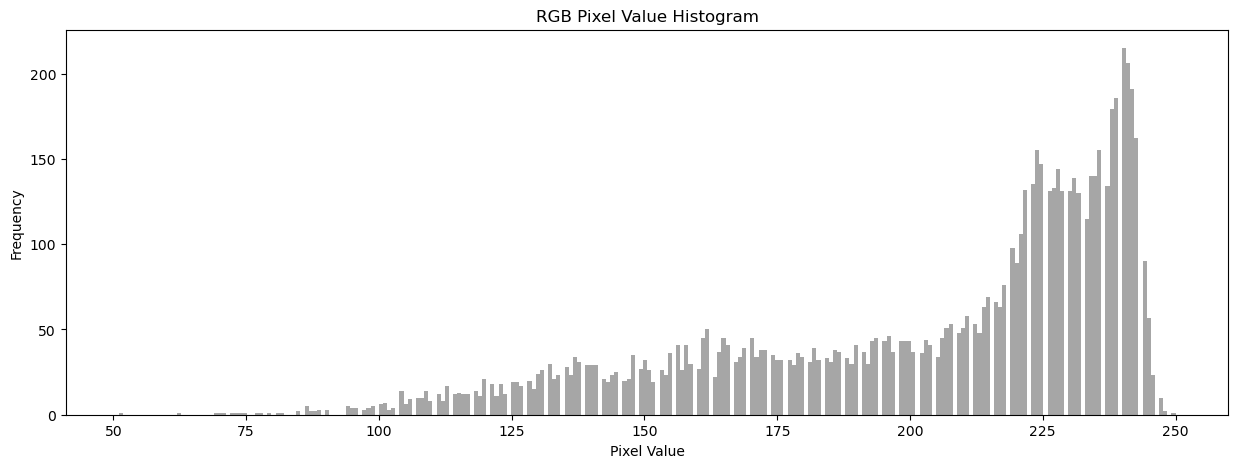

In [24]:
def plot_rgb_histogram(image):
    plt.figure(figsize=(15, 5))

    # Flatten the RGB values
    pixels = image.flatten()

    # Plot the histogram
    plt.hist(pixels, bins=256, color='gray', alpha=0.7)
    plt.title('RGB Pixel Value Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

selected_image = temp_df["Images"].iloc[np.random.randint(temp_df["Images"].shape[0])]
plot_rgb_histogram(selected_image)

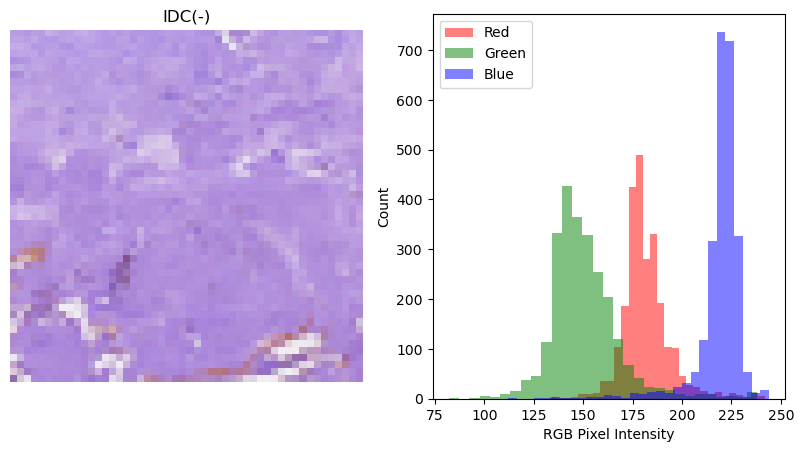

In [25]:
def plot_histogram(image, index):
    """
    Plot histogram of RGB Pixel Intensities
    """
    # Plot the image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('IDC(+)' if temp_df["Labels"].iloc[index] else 'IDC(-)')

    # Plot the RGB pixel intensity histograms
    histogram = plt.subplot(1, 2, 2)
    histogram.set_ylabel('Count')
    histogram.set_xlabel('RGB Pixel Intensity')
    
    n_bins = 30
    plt.hist(image[:,:,0].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5, label='Red')
    plt.hist(image[:,:,1].flatten(), bins=n_bins, lw=0, color='g', alpha=0.5, label='Green')
    plt.hist(image[:,:,2].flatten(), bins=n_bins, lw=0, color='b', alpha=0.5, label='Blue')
    plt.legend()

index = np.random.randint(temp_df["Images"].shape[0])
plot_histogram(temp_df["Images"].iloc[index], index)
plt.show()


Upon examining the average histogram of the images, it is evident that the most intense color or channel is blue (purpleish), aligning with expectations due to the H&E staining process. Hematoxylin (H), imparting a deep blue-purple color, and Eosin (E), contributing a pink hue, are common components of H&E staining.

### Model

Following this observation, the data is partitioned into Training, Development/Validation, and Test sets using distribution ratios of 0.75, 0.15, and 0.1, respectively. This strategic division enables the model to undergo training on 75% of the processed dataset, allocate 15% for validation/development, and reserve the remaining 10% for evaluating the model's performance.

In [26]:
#normalization
X = np.array(temp_df["Images"])
X = X / 255.0

# Split the data
X_train, X_temp_dev, Y_train, Y_temp_dev = train_test_split(X, temp_df["Labels"], test_size = 0.25)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp_dev, Y_temp_dev, test_size = 0.40)
print(type(X_train))
print(X_train[0].shape)

<class 'numpy.ndarray'>
(50, 50, 3)


Now we plot the distribution of data with respect to image classes.

In [27]:
# Print relevant data
positive_images = temp_df["Labels"].value_counts()[1]
negative_images = temp_df["Labels"].value_counts()[0]
total_images = len(temp_df["Labels"])

print("Number of IDC(+) images:", positive_images)
print("Number of IDC(-) images:", negative_images)
print("Percentage of IDC(+) images in the dataset:", f"{round((100 * positive_images) / total_images, 2)}%")
print("Percentage of IDC(-) images in the dataset:", f"{round((100 * negative_images) / total_images, 2)}%")


Number of IDC(+) images: 23684
Number of IDC(-) images: 59573
Percentage of IDC(+) images in the dataset: 28.45%
Percentage of IDC(-) images in the dataset: 71.55%


Recognizing the 1 to 3 positive-to-negative ratio in image patches, it's apparent that class imbalance may pose challenges during neural network training, leading to the Class Imbalance problem. To mitigate this issue, a sampling method is introduced for testing: Random Majority UnderSampling without Replacement. Before delving into these methods, data preparation is a crucial initial step.

In [28]:
# Flatten the data
X_train_shape = np.prod(X_train[0].shape)
X_dev_shape = np.prod(X_dev[0].shape)
X_test_shape = np.prod(X_test[0].shape)

X_train_flatten = np.array([image.flatten() for image in X_train]).reshape(-1, X_train_shape)
X_dev_flatten = np.array([image.flatten() for image in X_dev]).reshape(-1, X_dev_shape)
X_test_flatten = np.array([image.flatten() for image in X_test]).reshape(-1, X_test_shape)

print("X_train_flatten dimensions:", X_train_flatten.shape)
print("X_dev_flatten dimensions  :", X_dev_flatten.shape)
print("X_test_flatten dimensions :", X_test_flatten.shape)

X_train_flatten dimensions: (62442, 7500)
X_dev_flatten dimensions  : (12489, 7500)
X_test_flatten dimensions : (8326, 7500)


The positive-to-negative ratio of image patches is approximately 1:3. To address this imbalance, we will employ UnderSampling, reducing the number of negative examples to approximately 33% of their initial size, thereby aligning with the positive examples. Consequently, the total dataset size will be halved. This reduction is acceptable since the halved dataset remains substantial enough to impact our Neural Nets.

In [29]:
from keras.utils import to_categorical

def random_sample(sample_method):
    """
    Apply random sampling method to the data and reshape the features.
    """
    sm = sample_method
    X_train_sm, Y_train_sm = sm.fit_resample(X_train_flatten, Y_train)
    X_dev_sm, Y_dev_sm = sm.fit_resample(X_dev_flatten, Y_dev)
    X_test_sm, Y_test_sm = sm.fit_resample(X_test_flatten, Y_test)

    height, width, channels = 50, 50, 3
    X_train_sm_reshaped = X_train_sm.reshape(len(X_train_sm), height, width, channels)
    X_dev_sm_reshaped = X_dev_sm.reshape(len(X_dev_sm), height, width, channels)
    X_test_sm_reshaped = X_test_sm.reshape(len(X_test_sm), height, width, channels)

    return X_train_sm_reshaped, Y_train_sm, X_dev_sm_reshaped, Y_dev_sm, X_test_sm_reshaped, Y_test_sm
    

def make_hot_vector(Y_train, Y_dev, Y_test):
    """
    Encode the 'Labels' into the hot vector
    """
    Y_train_hot = to_categorical(Y_train, num_classes=2)
    Y_dev_hot = to_categorical(Y_dev, num_classes=2)
    Y_test_hot = to_categorical(Y_test, num_classes=2)
    return Y_train_hot, Y_dev_hot, Y_test_hot

# Using RandomUnderSampler for random sampling
X_train_rus, Y_train_rus, X_dev_rus, Y_dev_rus, X_test_rus, Y_test_rus = random_sample(RandomUnderSampler(sampling_strategy='auto'))
    
# Creating hot vectors for labels
Y_train_rus_hot, Y_dev_rus_hot, Y_test_rus_hot = make_hot_vector(Y_train_rus, Y_dev_rus, Y_test_rus)

# Printing dimensions of the reshaped datasets
print("X_train_rus Dimensions:", X_train_rus.shape)
print("X_dev_rus Dimensions   :", X_dev_rus.shape)
print("X_test_rus Dimensions  :", X_test_rus.shape)


X_train_rus Dimensions: (35572, 50, 50, 3)
X_dev_rus Dimensions   : (7102, 50, 50, 3)
X_test_rus Dimensions  : (4694, 50, 50, 3)


Some Helper Functions to help plot the Confusion Matrix and the learning Curve.

In [30]:
def plot_confusion_matrix(X_data, Y_data_hot, title):
    """
    Plot the confusion matrix for a given model's predictions.

    Parameters:
    - X_data: Input data
    - Y_data_hot: One-hot encoded true labels
    - title: Title of the plot

    Returns:
    - cm_plot: Plot of the confusion matrix
    """
    Y_pred_one_hot = model.predict(X_data)
    Y_pred_labels = np.argmax(Y_pred_one_hot, axis=1)
    Y_true_labels = np.argmax(Y_data_hot, axis=1)
    confusion_matrix = metrics.confusion_matrix(y_true=Y_true_labels, y_pred=Y_pred_labels)

    cm_df = pd.DataFrame(confusion_matrix, index=["IDC(-)", "IDC(+)"], columns=["IDC(-)", "IDC(+)"])
    cm_plot = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Greens")  # Green color scheme
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=12)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm_plot


def plot_learning_curve(training):
    """
    Plot the learning curve of a model's training history.

    Parameters:
    - training: Model training history

    Returns:
    - None
    """
    plt.clf()
    plt.figure(figsize=(10, 10))

    # Determine the key for accuracy
    accuracy_key = 'accuracy' if 'accuracy' in training.history else 'acc'

    # Plot the entire model history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(training.history[accuracy_key])
    plt.plot(training.history['val_' + accuracy_key])  # Assuming you have validation data
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('accuracy_curve.png')

    # Plot the entire model history for losses
    plt.subplot(1, 2, 2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

The Convolutional Neural Network (CNN) architecture described here employs a series of convolutional blocks, each consisting of three consecutive 3x3 convolutional layers with increasing numbers of filters (32, 64, 128). The overall network architecture is structured with padding strategies, alternating between 'same' and 'valid' padding, followed by 1x1 convolutions and 2x2 max pooling layers. The activation function for all layers, except the final dense layer, is Rectified Linear Unit (ReLU), chosen for its simplicity and effectiveness. The final output layer uses the sigmoid activation function to output probabilities. 

The decision to use only 3x3 convolutional kernels is based on optimizing receptive field coverage and reducing the number of trainable parameters. Dropout is omitted to avoid information loss during testing, and dense layers are limited, preserving spatial information. BatchNormalization did not significantly contribute to performance improvement and was excluded from the architecture. The design choices aim to balance computational efficiency, regularization, and preservation of spatial features in the breast cancer detection CNN.

In [31]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50,50,3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='valid',activation='relu'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))


model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1, 1), padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='sigmoid'))
# print out model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        4128      
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 128)       7

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#  'model' is the neural network model
model_architecture = []

# Iterate through layers in the model
for i, layer in enumerate(model.layers):
    layer_info = {
        'Layer Number': i + 1,
        'Layer Type': type(layer).__name__,
        'Output Shape': layer.output_shape,
        'Activation Function': layer.get_config().get('activation', 'N/A')
    }
    model_architecture.append(layer_info)

# Create a DataFrame from the model architecture information
architecture_table = pd.DataFrame(model_architecture)

# Display the model architecture table
print(architecture_table)


    Layer Number              Layer Type         Output Shape  \
0              1                  Conv2D   (None, 50, 50, 32)   
1              2                  Conv2D   (None, 50, 50, 64)   
2              3                  Conv2D  (None, 50, 50, 128)   
3              4                  Conv2D   (None, 50, 50, 32)   
4              5                  Conv2D   (None, 48, 48, 32)   
5              6                  Conv2D   (None, 46, 46, 64)   
6              7                  Conv2D  (None, 44, 44, 128)   
7              8                  Conv2D   (None, 44, 44, 32)   
8              9            MaxPooling2D   (None, 22, 22, 32)   
9             10                  Conv2D   (None, 20, 20, 32)   
10            11                  Conv2D   (None, 18, 18, 64)   
11            12                  Conv2D  (None, 16, 16, 128)   
12            13                  Conv2D   (None, 16, 16, 32)   
13            14            MaxPooling2D     (None, 8, 8, 32)   
14            15         

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

In [34]:
# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00033),
              metrics=['accuracy'])


Data augmentation techniques will not be employed in this project due to their prolonged training time (approximately twice as much) without a substantial improvement in the training/validation accuracy. The dataset, even after undergoing undersampling, is deemed sufficiently large to yield satisfactory results. Despite experimenting with various combinations of data augmentation techniques, there was minimal to no observable increase in accuracy. The decision to forgo data augmentation is based on the trade-off between training time and the marginal benefits observed in the context of the breast cancer detection task.

In [35]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False, #True,
    featurewise_std_normalization=False) #, #True,

To save checkpoints of the model to an output file.

In [36]:
# For early stopping of model
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=25, mode='min')

# To create checkpoints after each improvement of validation loss and save it in a .h5 file
model_checkpoint = ModelCheckpoint('model_weights/best-mdl_cp_new.h5', monitor='val_loss',\
                                    verbose=1, mode='auto', save_best_only=False)


In [37]:
batch_size = 256
num_classes = 2
epochs = 10 #50 #180 #200

training = model.fit(datagen.flow(X_train_rus,\
                                            Y_train_rus_hot,\
                                            batch_size=batch_size),\
                                            steps_per_epoch=(len(X_train_rus)/batch_size),\
                                            epochs=epochs,\
                                            validation_data=(X_dev_rus, Y_dev_rus_hot),\
                                            verbose=1,\
                                            callbacks=[early_stopping_monitor, model_checkpoint])#, history])

Epoch 1/10
139/138 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.6998
Epoch 1: saving model to model_weights/best-mdl_cp_new.h5
138/138 [==============================] - 417s 3s/step - loss: 0.5780 - accuracy: 0.6998 - val_loss: 0.5468 - val_accuracy: 0.7582
Epoch 2/10


/Users/ishapatel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/138 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.7857
Epoch 2: saving model to model_weights/best-mdl_cp_new.h5
138/138 [==============================] - 425s 3s/step - loss: 0.4855 - accuracy: 0.7857 - val_loss: 0.5033 - val_accuracy: 0.7816
Epoch 3/10
139/138 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7899
Epoch 3: saving model to model_weights/best-mdl_cp_new.h5
138/138 [==============================] - 454s 3s/step - loss: 0.4714 - accuracy: 0.7899 - val_loss: 0.4400 - val_accuracy: 0.8039
Epoch 4/10
139/138 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8060
Epoch 4: saving model to model_weights/best-mdl_cp_new.h5
138/138 [==============================] - 486s 3s/step - loss: 0.4407 - accuracy: 0.8060 - val_loss: 0.4290 - val_accuracy: 0.8072
Epoch 5/10
139/138 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8072
Epoch 5: saving model to model_weights/best-mdl_cp_new.h5

The training set achieves an accuracy of approximately 0.8325, while the validation set accuracy is around 0.8305. The intentional overfitting of the training set is motivated by the observation that, despite the validation set's loss increasing after approximately 10 epochs, its accuracy continues to rise. This strategy prioritizes training set performance, acknowledging a decrease in the average probability/confidence of predictions in the validation set. 

The key test lies in evaluating the model's effectiveness on the test set to validate its generalization capability beyond the training and validation sets. This will determine if the model's success extends beyond luck with the validation set to offer reliable predictions for unseen data.

In [38]:
# Test set score
score = model.evaluate(X_test_rus, Y_test_rus_hot, verbose=1)
print("Test set loss     : ", score[0])
print("Test set accuracy : ", score[1])
#model.get_weights()

147/147 [==============================] - 20s 136ms/step - loss: 0.3862 - accuracy: 0.8294
Test set loss     :  0.38624343276023865
Test set accuracy :  0.8293566107749939



Despite intentionally overfitting the training set, the model demonstrates robust performance, with both the validation and test sets achieving an accuracy within the range of 83%. This outcome suggests the model's ability to generalize well to unseen data, showcasing its reliability and effectiveness in breast cancer detection.

In the context of medical data, precision and recall metrics hold more significance than overall accuracy. Precision and recall provide insights into the model's ability to correctly identify positive and negative image patches. To better understand the model's performance, an exploration of these metrics will be undertaken.

In [39]:
def scores(X_data, Y_data_hot):

# Add a batch dimension
    Y_pred_one_hot = model.predict(X_data)
    Y_pred_labels = np.argmax(Y_pred_one_hot, axis=1)
    Y_true_labels = np.argmax(Y_data_hot, axis=1)

    true_positives = np.sum(np.round(np.clip(Y_true_labels * Y_pred_labels, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(Y_pred_labels, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(Y_true_labels, 0, 1)))

    epsilon = 1e-07
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (possible_positives + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

# If 'accuracy' is used as the key, use 'accuracy', otherwise use 'acc'
accuracy_key = 'accuracy' if 'accuracy' in training.history else 'acc'

# assign all the metrics to 'data' variable
data = [scores(X_train_rus, Y_train_rus_hot), scores(X_dev_rus, Y_dev_rus_hot), \
        scores(X_test_rus, Y_test_rus_hot)]

# Create the pandas DataFrame 
all_metrics = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1_score'], \
                            index=['Train', 'Validation', 'Test'])

all_metrics['Accuracy'] = [training.history[accuracy_key][-1], \
                            training.history['val_' + accuracy_key][-1], score[1]]

all_metrics


147/147 [==============================] - 22s 152ms/step


Precision    Recall  F1_score  Accuracy
Train        0.864951  0.797256  0.829725  0.832537
Validation   0.859859  0.789637  0.823253  0.830470
Test         0.860205  0.786536  0.821723  0.829357

The precision-recall pairs of both the Validation set and Test set are consistent, indicating that despite overfitting in the training set, the accuracy, precision, recall, and f1_score for previously unseen data are within the same range. This demonstrates the robustness of the model.

In the original trained model, the Recall score is intentionally higher than Precision for both the validation and test sets. This deliberate choice aligns with the nature of laboratory diagnosis, where prioritizing the correct identification of positive cases (illness) is crucial. The Recall-Precision pair signifies that a higher Recall score increases the probability of correctly predicting a person with an illness. While increasing Recall may decrease Precision, the model has been optimized to strike a balance, ensuring a reasonable Recall advantage without significantly compromising Precision. 


The confusion matrix serves as a valuable tool for visualizing data reporting errors, particularly in distinguishing between False Positives, False Negatives, True Positives, and True Negatives.

147/147 [==============================] - 20s 137ms/step


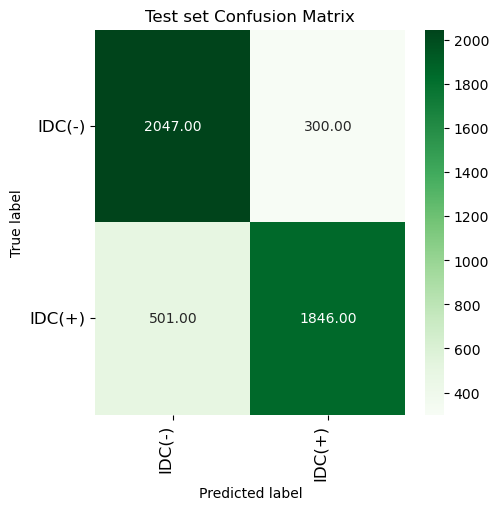

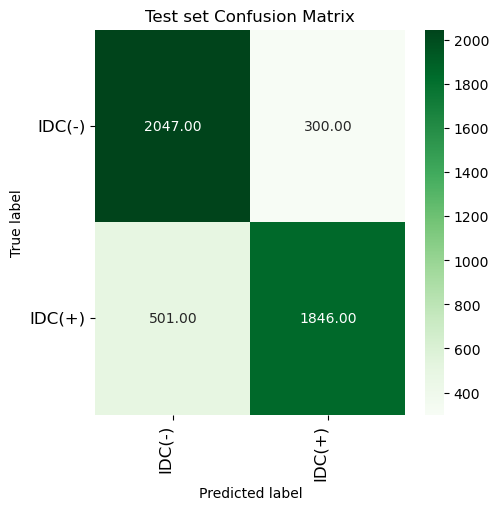

In [40]:
from sklearn import metrics

# Test set confusion matrix
plot_confusion_matrix(X_test_rus, Y_test_rus_hot, title="Test set Confusion Matrix")

Plotting the learning curve allows us to visually analyze the model's accuracy and loss trends throughout the training process.

<Figure size 500x500 with 0 Axes>

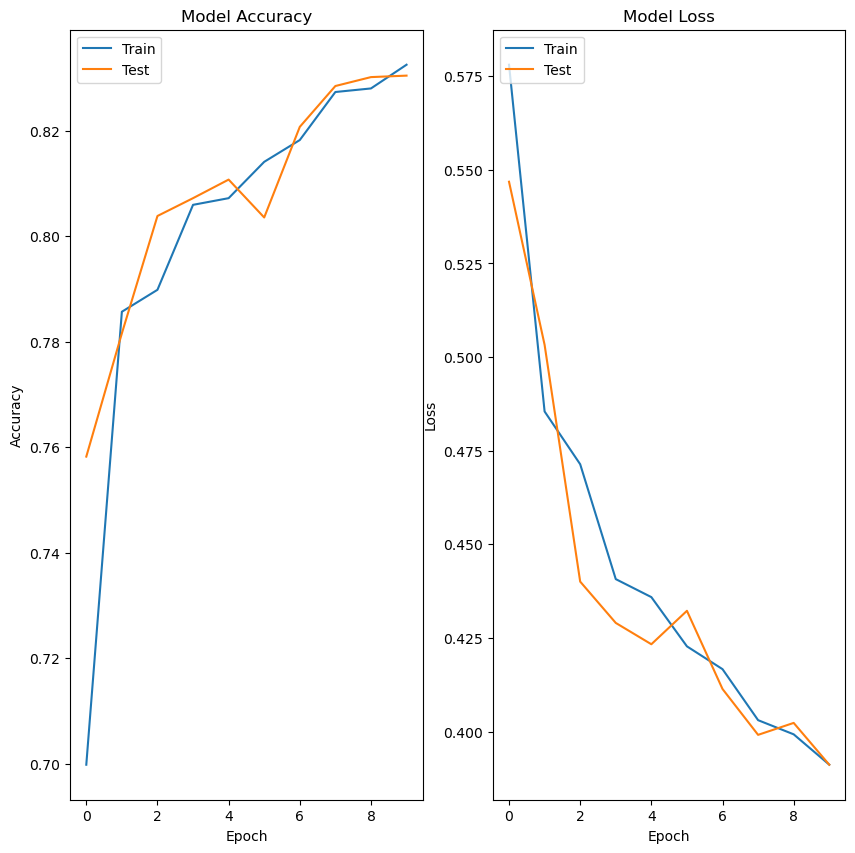

In [41]:
plot_learning_curve(training)

In an alternative model with a slightly different CNN architecture and a lower learning rate (0.00001) run for 150 epochs, the validation accuracy achieved approximately 85%, with a variation of 1-2%. This model exhibited similar recall and precision scores, without a clear indication of overfitting. However, the emphasis on minimizing False Negatives over False Positives is highlighted. The preference is to err on the side of caution, even if it results in a slight increase in False Positives, as False Negatives are considered more undesirable in medical diagnoses. The pursuit is for an optimal balance between recall and precision that aligns with acceptable trade-offs.

The analysis provides insights into recall-precision pairs and the trade-offs between False Positives and False Negatives, emphasizing the importance of minimizing False Negatives in medical diagnoses. However, the drawbacks of the model are not explicitly detailed in the summary. The author mentions introducing precision-recall plots for the entire unbalanced dataset and corresponding confusion matrices as a means of illustrating these drawbacks, suggesting a visual representation of model limitations and areas for improvement.

147/147 [==============================] - 20s 133ms/step


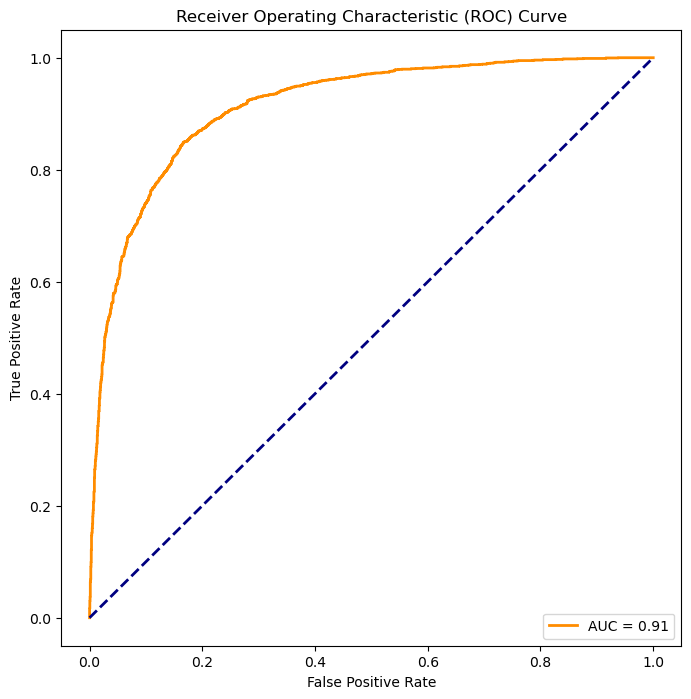

In [43]:
# ROC CURVVEE
from sklearn.metrics import roc_curve, auc

# Assuming 'model' is your trained model and X_test, Y_test_hot are your test data
# Add a batch dimension
Y_pred_prob = model.predict(X_test_rus)
Y_true_labels = np.argmax(Y_test_rus_hot, axis=1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_true_labels, Y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
